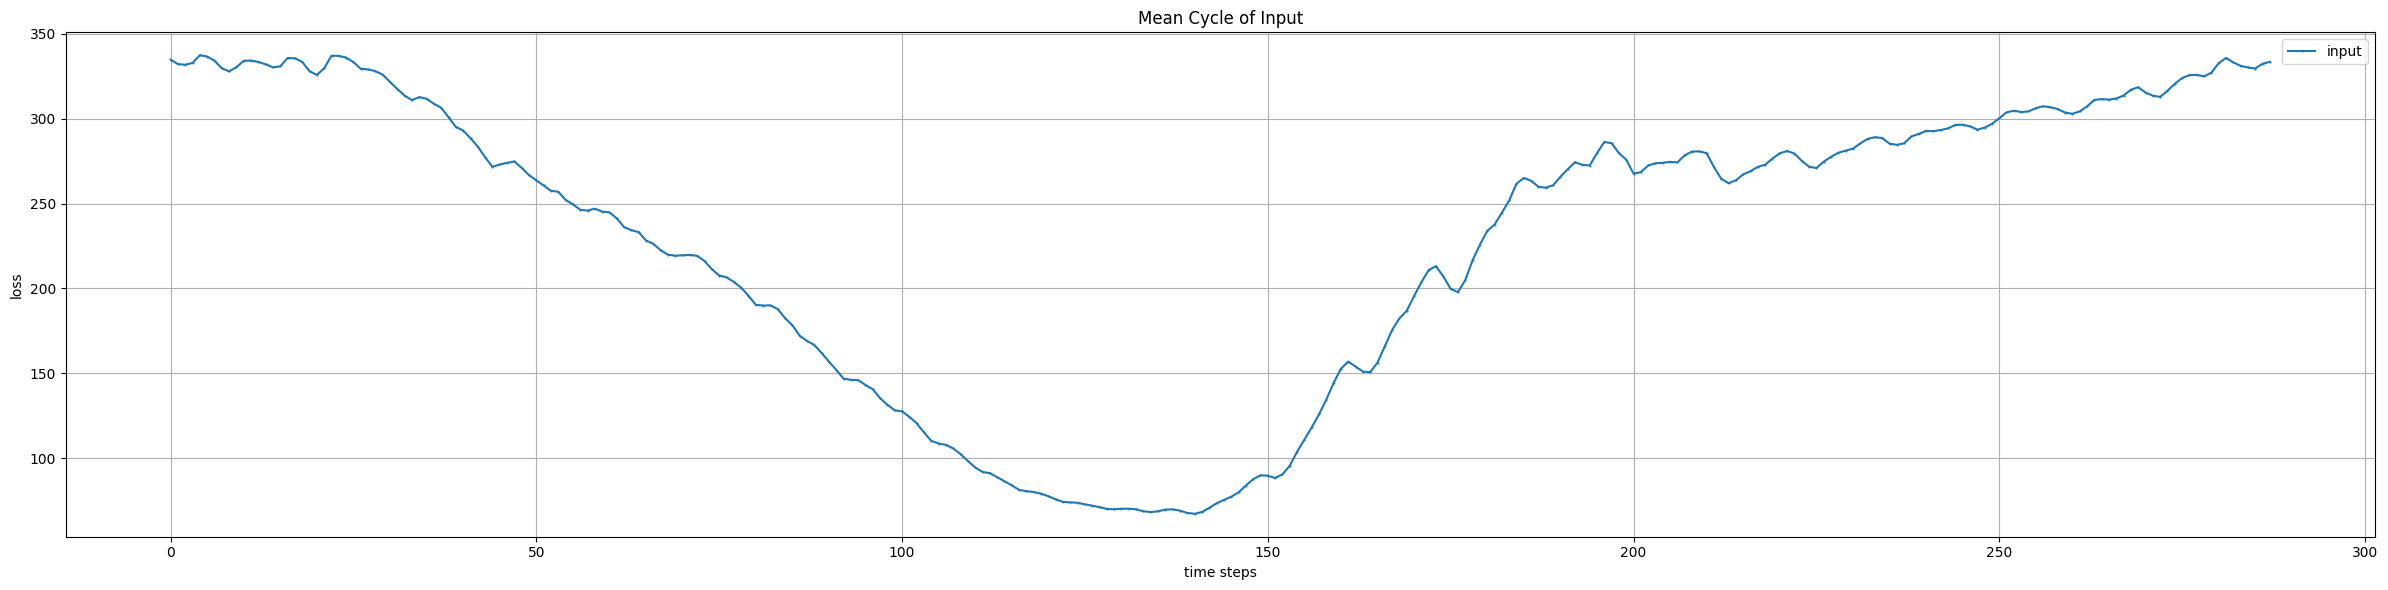

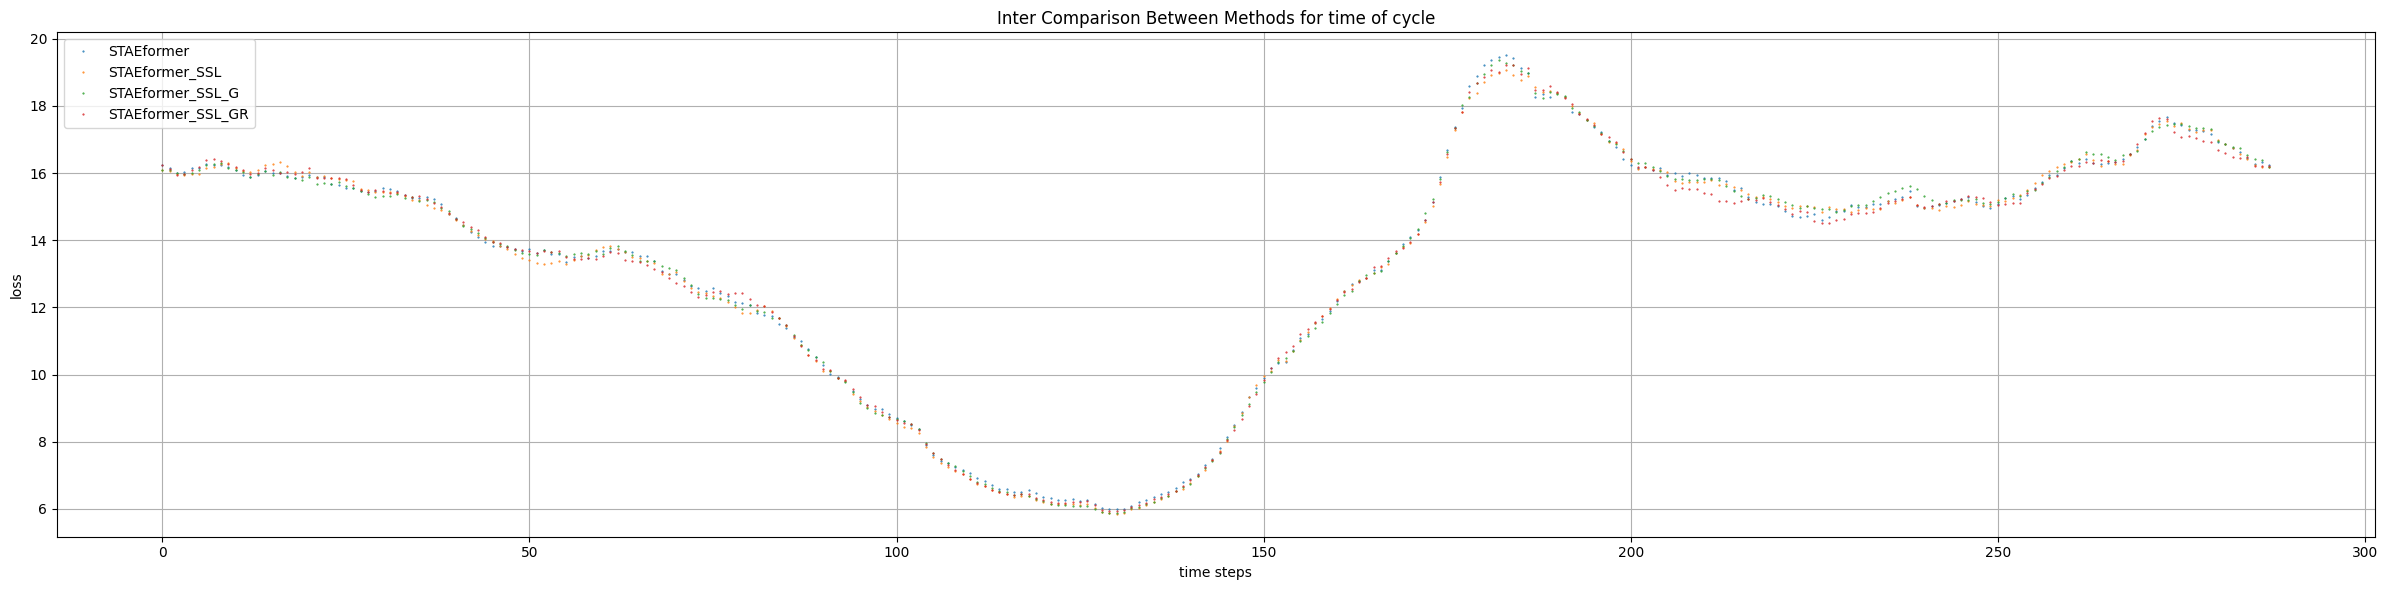

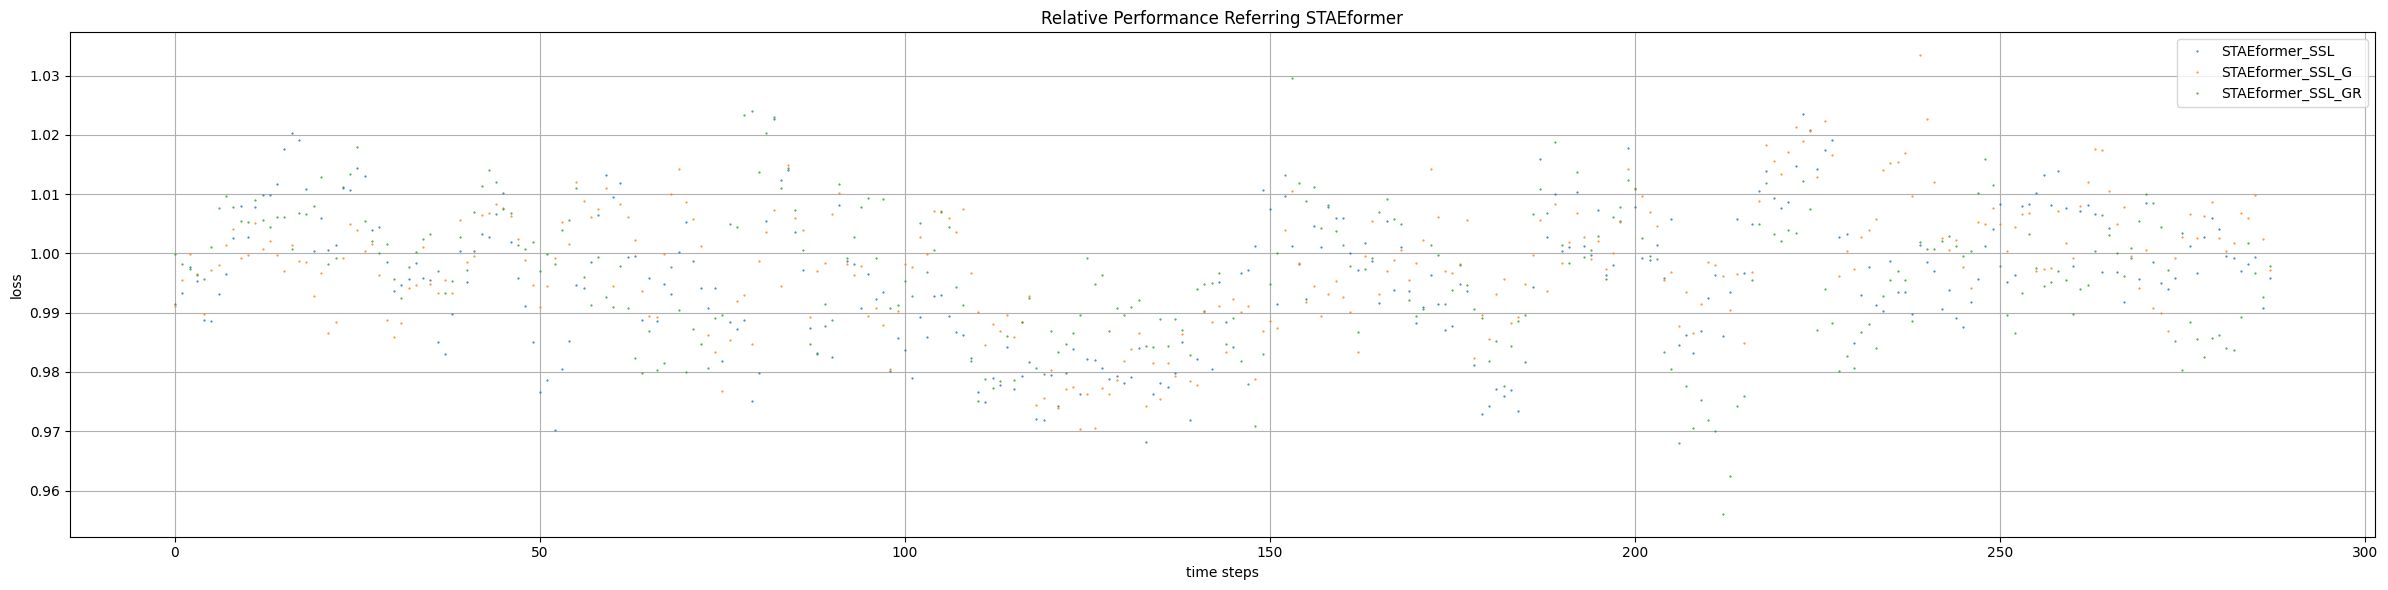

/tmp/ipykernel_1600387/3214981150.py:34: RuntimeWarning: overflow encountered in exp
  mean_soft_label = np.mean(np.mean(2/(np.exp(mse)+1), axis=-1), axis=-1)


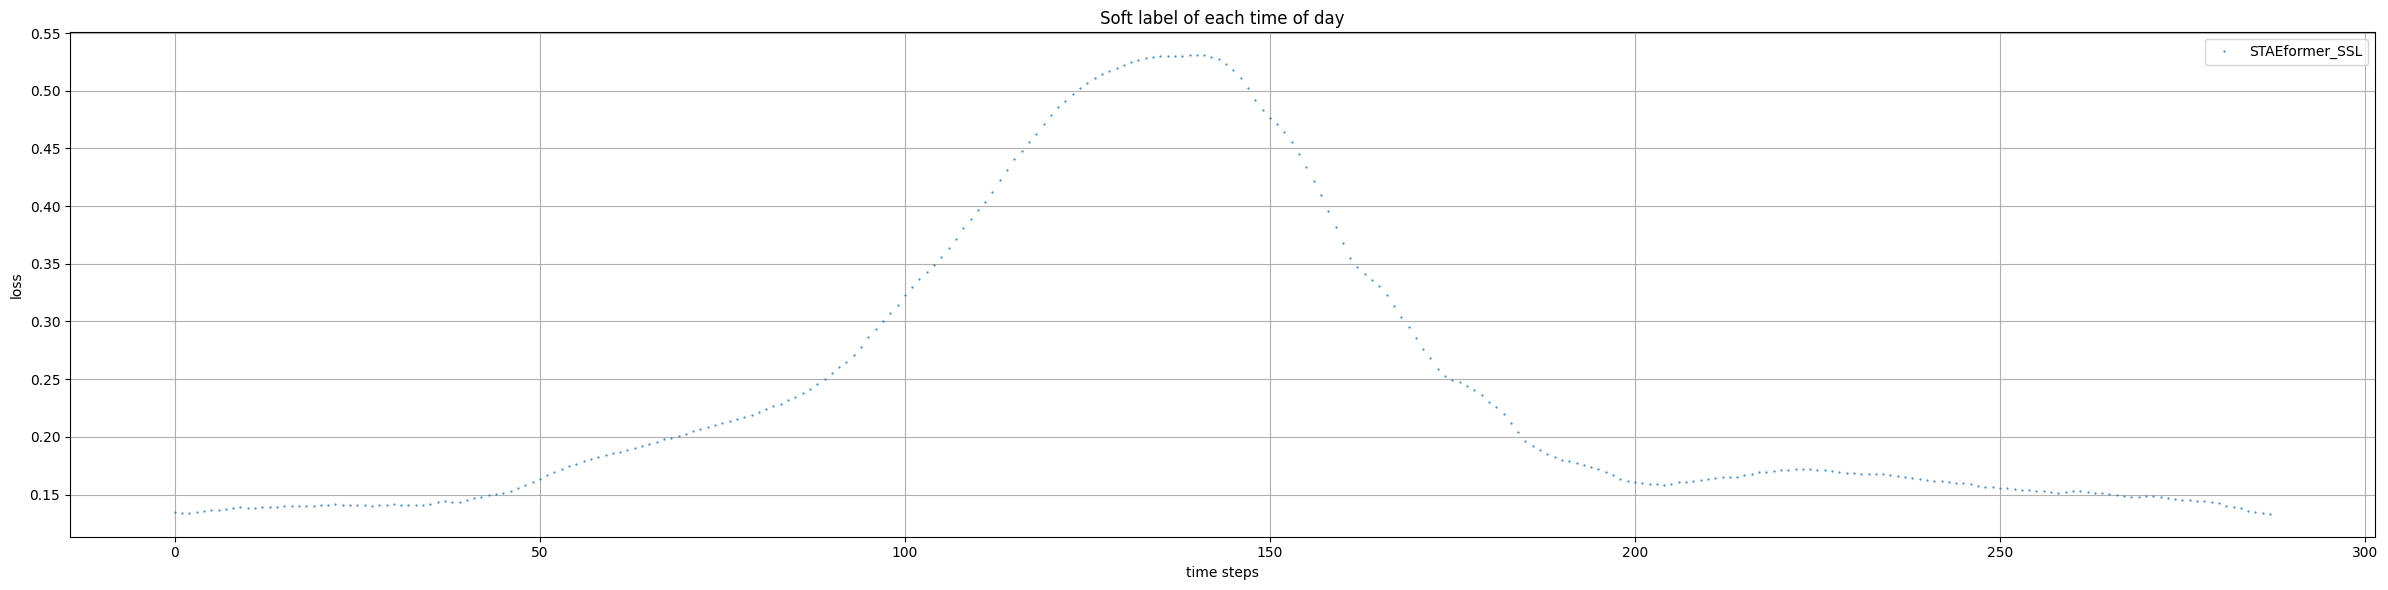

In [1]:
import torch
from baselines.MyModel.arch.MyFormer import moving_avg
from basicts.utils.result import data_group_by_node_and_cycle, read_result_file
from typing import List
import numpy as np

from basicts.utils.visualize import plot_line


def compute_soft_label(file_path: str, cycle: int = 288, trend: bool = False):
    obj = read_result_file(file_path)
    # (I, T, N, C) -> (I, T, N) -> (I, N, T)
    inputs = obj['inputs'][:, :, :, 0]
    m, s = np.mean(inputs), np.std(inputs)
    inputs = (inputs - m) / s
    if trend:
        ma = moving_avg(kernel_size=3, stride=1)
        inputs = torch.from_numpy(inputs).float()
        trend = ma(inputs).cpu().numpy()
        inputs = inputs.cpu().numpy()
        inputs = inputs - trend
    inputs = np.transpose(inputs, (0, 2, 1))
    count_cycles = inputs.shape[0] // cycle
    inputs = inputs[:count_cycles * cycle]
    # note 计算两两之间的mse
    # (I, N, T) -> (I, N)
    inputs_pow = np.sum(np.power(inputs, 2), axis=-1)
    # (I, N, T) @ (I, T, N) -> (I, N, N)
    inputs_prod = np.matmul(inputs, inputs.transpose((0, 2, 1)))
    # (I, 1, N) - (I, N, N) + (I, N, 1) -> (I, N, N)
    mse = np.expand_dims(inputs_pow, -2) + np.expand_dims(inputs_pow, -1) - 2 * inputs_prod
    # note 计算每一个时间步的平均label
    # (I, N, N) -> (I)
    mean_soft_label = np.mean(np.mean(2/(np.exp(mse)+1), axis=-1), axis=-1)
    return mean_soft_label

def visualize_mae_cycle_distri(method_result_files: List[str],
                               method_names: List[str],
                               cycle_timestamps: int,
                               referred_id: int):
    """
    这一个cell的目的，是展示不同方法产生的预测结果，在一个循环周期内的分布，外加展示每一个时间片内部时间序列的相似程度
    :param method_result_files: 不同方法的预测结果文件
    :param method_names: 方法的名称
    :param cycle_timestamps: 一个循环包括多少时间步
    """
    mae_grouped_by_time_of_cycle = []
    inputs_cycle = None
    for file in method_result_files:
        # (N, cycle_timestamps, C) -> (cycle_timestamps)
        mae_grouped_by_node_and_time_of_cycle, input_grouped_by_node_and_time_of_cycle = data_group_by_node_and_cycle(file, cycle_timestamps)
        mae_grouped_by_node_and_time_of_cycle = mae_grouped_by_node_and_time_of_cycle[:, :, 0]
        input_grouped_by_node_and_time_of_cycle = input_grouped_by_node_and_time_of_cycle[:, :, 0]
        # (N, I, C)
        inputs_cycle = input_grouped_by_node_and_time_of_cycle
        mae_grouped_by_node_and_time_of_cycle = np.mean(mae_grouped_by_node_and_time_of_cycle, axis=0)
        mae_grouped_by_time_of_cycle.append(mae_grouped_by_node_and_time_of_cycle)
    inputs_cycle = np.mean(inputs_cycle, axis=0)
    plot_line(title="Mean Cycle of Input",
              x=[i for i in range(cycle_timestamps)], ys=[inputs_cycle],
              y_names=["input"], no_line=False)
    plot_line(title="Inter Comparison Between Methods for time of cycle",
              x=[i for i in range(cycle_timestamps)], ys=mae_grouped_by_time_of_cycle,
              y_names=method_names, no_line=True)
    relative_mae_grouped_by_time_of_cycle = []
    relative_names = []
    for idx, (mae, name) in enumerate(zip(mae_grouped_by_time_of_cycle, method_names)):
        if idx != referred_id:
            relative_mae_grouped_by_time_of_cycle.append(mae / mae_grouped_by_time_of_cycle[referred_id])
            relative_names.append(name)
    plot_line(title=f"Relative Performance Referring {method_names[referred_id]}",
            x=[i for i in range(cycle_timestamps)], ys=relative_mae_grouped_by_time_of_cycle,
            y_names=relative_names, no_line=True)
    mean_soft_label = compute_soft_label(method_result_files[0], trend=False)
    mean_soft_label = mean_soft_label.reshape(-1, 288)
    mean_soft_label = np.mean(mean_soft_label, axis=0)
    plot_line(title=f"Soft label of each time of day",
            x=[i for i in range(cycle_timestamps)], ys=[mean_soft_label],
            y_names=relative_names, no_line=True)

# 预测文件
prediction_files_pems08 = [
    "../checkpoints/STAEformer/PEMS08_100_12_12/70ceb2d1dd84b5dc181774f2d16a14c1/test_results.npz",
    #"../checkpoints/DecomposeFormer_adv/PEMS08_100_12_12/165deb5b6eed720c6bd224ec75f4585a/test_results.npz",
    #"../checkpoints/DecomposeFormer_TTS/PEMS08_100_12_12/d7fde011127742d7ea670292ecf8abd9/test_results.npz",
    "../checkpoints/STAEformer_SSL/PEMS08_100_12_12/0626548526f8a5dbc470d995fb7d8ffa/test_results.npz",
    #"../checkpoints/DecomposeFormer_TTS_SSL/PEMS08_100_12_12/89e7d7c9a5f7e553643a4ef6ba8226b2/test_results.npz",
    "../checkpoints/STAEformer_SSL_G/PEMS08_100_12_12/da07ac4fc56a211b4813b242a4f732b4/test_results.npz",
    "../checkpoints/STAEformer_SSL_G/PEMS08_100_12_12/f6a91530204e83a0cdb896d776b2814b/test_results.npz",
    #"../checkpoints/DecomposeFormer_TTS_BT/PEMS08_100_12_12/e1f24853775a8ea589a35090f4e97375/test_results.npz",
    #"../checkpoints/DecomposeFormer_TTS_TBT/PEMS08_100_12_12/84151c07bf117e24d1cf0c6ba5ce40fa/test_results.npz",

]
prediction_files_pems04 = [
    "../checkpoints/STAEformer/PEMS04_100_12_12/847a2ce08791eb89c3a325b199127003/test_results.npz",
    "../checkpoints/DecomposeFormer_adv/PEMS04_100_12_12/3b4d38f791b9a5449d5058ad504b18a0/test_results.npz",
    "../checkpoints/STAEformer_SSL/PEMS04_100_12_12/6cb833695c71cb7ce824ef6ebdd71aab/test_results.npz",
]
# 方法名称
method_names = [
    "STAEformer",
    #"DecomposeFormer_adv_w_trend",
    #"DecomposeFormer_TTS_w_trend",
    "STAEformer_SSL",
    #"DecomposeFormer_TTS_S_SSL",
    "STAEformer_SSL_G",
    "STAEformer_SSL_GR",
    #"DecomposeFormer_TTS_BT",
    #"DecomposeFormer_TTS_TBT"
]
# 时间步
cts = 288
visualize_mae_cycle_distri(prediction_files_pems08, method_names, cts, 0)